In [163]:
import datetime
import requests
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

article='Kawhi_Leonard'
start_t = '20150701'
granularity = 'daily'
end_t = datetime.datetime.now().strftime('%Y%m%d')
url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/user/'
param_str = f'{article}/{granularity}/{start_t}/{end_t}'
    
url = url + param_str
response = requests.get(url)
df = pd.DataFrame(response.json()['items'])
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d00')
df = df.rename(columns={'timestamp': 'ds', 'views': 'y'})
df = df.set_index('ds')

In [164]:
train = df['2015':'2017']
test  = df['2018':'2019']
train = train.reset_index()
test = test.reset_index()

In [161]:
#Mean Baseline
train['mean_baseline'] = train['y'].mean()
test['mean_baseline'] = train['y'].mean()
#Naive Baseline
train['naive_baseline'] = train['y'].shift(1).bfill()
test['naive_baseline'] = train['y'].iloc[-1]

In [158]:
from sklearn.metrics import mean_absolute_error
print('MAE for Mean Baseline')
print('Train:\t', mean_absolute_error(train['y'], train['mean_baseline']))
print('Test:\t', mean_absolute_error(test['y'], test['mean_baseline']))
print('\nMAE for Naive Baseline')
print('Train:\t', mean_absolute_error(train['y'], train['naive_baseline']))
print('Test:\t', mean_absolute_error(test['y'], test['naive_baseline']))

MAE for Mean Baseline
Train:	 2724.871937651169
Test:	 5849.029296875

MAE for Naive Baseline
Train:	 2119.886338797814
Test:	 6429.810546875


In [141]:

from fbprophet import Prophet
m = Prophet()
m.fit(train)
train_forcast = m.predict(train)
test_forcast = m.predict(test)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [142]:
print('\nMAE for Prophet Predictions')
print('Train:\t', mean_absolute_error(train['y'], train_forcast['yhat']))
print('Test:\t', mean_absolute_error(test['y'], test_forcast['yhat']))


MAE for Prophet Predictions
Train:	 1881.9042952217362
Test:	 7282.263252201357


In [143]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, horizon='100 days', period='180 days')

INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-09-27 00:00:00 and 2017-09-22 00:00:00


In [144]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-09-28,1293.322529,-2726.586408,4809.110771,1343,2016-09-27
1,2016-09-29,909.041524,-3057.506956,4794.824582,1409,2016-09-27
2,2016-09-30,1261.099922,-2553.891358,5263.131909,1295,2016-09-27
3,2016-10-01,1058.244182,-2913.648913,5267.474137,1308,2016-09-27
4,2016-10-02,1287.008891,-2255.667637,5254.649872,1346,2016-09-27


In [145]:
from fbprophet.diagnostics import performance_metrics
performance_metrics(df_cv).head()

,horizon,mse,rmse,mae,mape,coverage
0,10 days,1.624393e+07,4030.375684,2136.665943,0.324962,0.800000
1,11 days,1.632691e+07,4040.656804,2188.774735,0.342282,0.800000
2,12 days,1.042176e+07,3228.274915,1718.156340,0.288686,0.833333
3,13 days,1.031362e+07,3211.482302,1691.364270,0.298393,0.833333
4,14 days,6.908311e+06,2628.366598,1454.265830,0.307785,0.866667


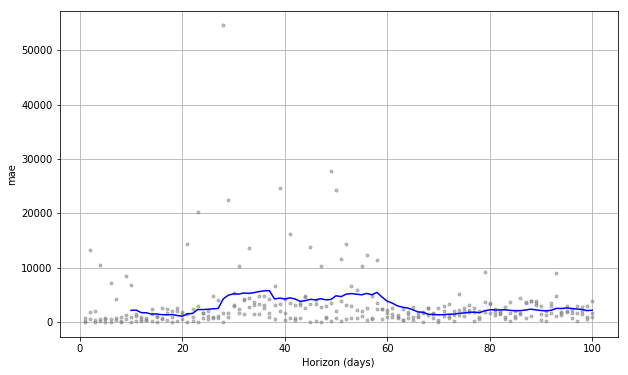

In [146]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')

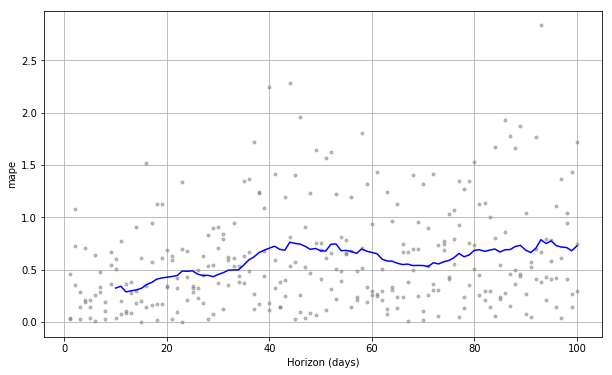

In [147]:
fig = plot_cross_validation_metric(df_cv, metric='mape')